In [ ]:
# Tiny backpropogation project based on Andrej Karpathy's micrograd
# https://youtu.be/VMj-3S1tku0?si=jnUb6sYZusVZb-u1

In [70]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
class Value:
    def __init__(self, data, _children=(), _operation='', label=''):
        self.label = label
        self.data = data
        self.gradient = 0.0
        self._backward = lambda : None # eg for leaf node
        self._prev = set(_children)
        self._operation = _operation

    def __repr__(self):
        return f"Value(label={self.label},data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data+other.data, (self, other), '+')
        
        def _backward():
            self.gradient += 1.0 * result.gradient
            other.gradient += 1.0 * result.gradient
        result._backward = _backward
        return result

    def __radd__(self, other):
        return self - other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return self-other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.gradient += other.data * result.gradient
            other.gradient += self.data * result.gradient
        result._backward = _backward
        return result

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data*other.data**-1, (self, other), '/')
        return result

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        result = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.gradient += (other * (self.data ** (other-1))) * result.gradient
        result._backward = _backward
        return result

    def exp(self, other):
        converted = np.float128(self.data)
        result = Value(np.exp(converted), (self, ), 'exp')

        def _backward():
            self.gradient += result * result.gradient
        result._backward = _backward
        return result

    def __neg__(self):
        return self * -1

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        result = Value(t, (self, ), 'tanh')

        def _backward():
            self.gradient += (1-t**2) * result.gradient
        result._backward = _backward
        return result
    
    def relu(self):
        out = Value(self.data if self.data > 0 else 0, (self,), 'ReLU')

        def _backward():
            self.gradient += out.gradient if self.data > 0 else 0
        out._backward = _backward
        
    def backward(self):
        topo=[]
        visited=set()
        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)
        topo_sort(self)
        self.gradient=1.0
        for node in reversed(topo):
            node._backward()


In [91]:
x = Value(2.0)
t = x**2
c = Value(-5.0)
v = t + c

In [92]:
v.backward()
x.gradient

4.0

In [146]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | gradient %.4f }" % (n.label, n.data, n.gradient), shape='record')
        if n._operation:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._operation, label = n._operation)
            # and connect this node to it
            dot.edge(uid + n._operation, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot

In [152]:
class Neuron:

    def __init__(self, num_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, input):
        # do a dot product + b
        act = sum(wi*xi for wi, xi in zip(self.w, input)) + self.b
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    # fully connected layer
    def __init__(self, num_in, num_out):
        self.neurons = [Neuron(num_in) for _ in range(num_out)]

    def __call__(self, input):
        outputs = [n(input) for n in self.neurons]
        return outputs[0] if len(outputs)==1 else outputs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class Network:
    # where num_out is a list of integers(number of nuerons of each layer)
    # num_in is number of samples
    def __init__(self, num_in, num_out):
        layer_sizes = [num_in] + num_out
        self.layers = [Layer(layer_sizes[i], layer_sizes[i+1]) for i in range(len(num_out))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def train(self, xs, ys, iterations=20, constant=0.1):
        for k in range(iterations):
            ypred = [self(x) for x in xs]
            loss = sum((y_out - y_true)**2 for y_true, y_out in zip(ys, ypred))
            
            for p in self.parameters():
                p.gradient = 0.0
            
            loss.backward()

            for p in self.parameters():
                p.data += -constant * p.gradient

        print(k, loss.data)
        return loss

In [153]:
# XOR Gate
xs = [
  [1.0, 1.0],
  [1.0, 0.0],
  [0.0, 1.0],
  [0.0, 0.0],
]
ys = [0.0, 1.0, 1.0, 0.0] # targets

99 0.10698516718867707


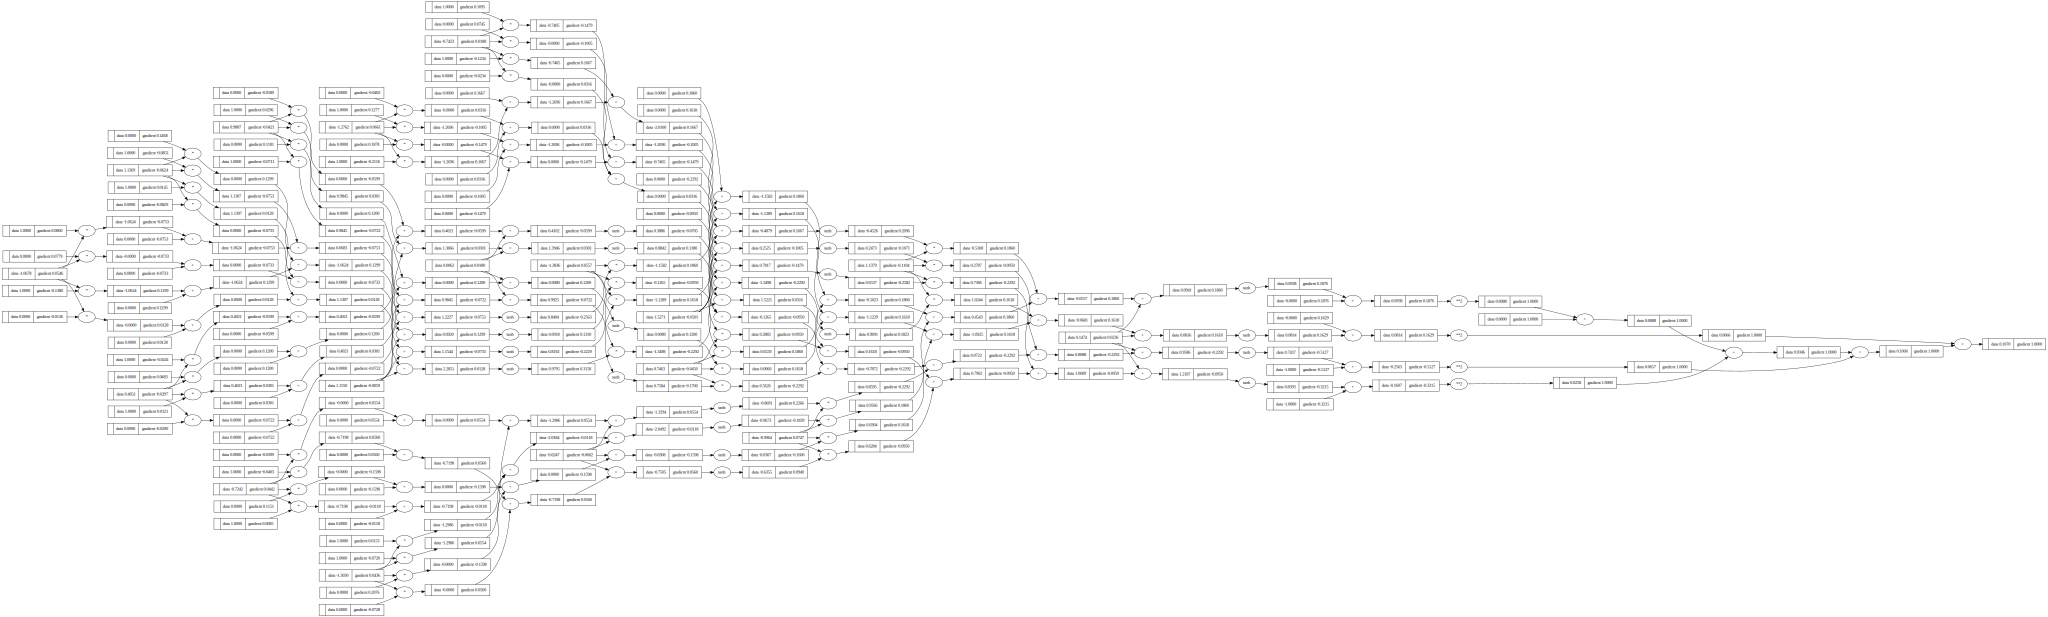

In [154]:
nuerons = [4, 1]
network = Network(len(xs), nuerons)
loss = network.train(xs, ys, 100, 0.1)
draw_dot(loss)

In [155]:
pos_test = [1.0, 1.0]
neg_test = [0.0, 1.0]
print(network(pos_test))
print(network(neg_test))

Value(label=,data=0.09037513618870013)
Value(label=,data=0.7486725232441753)
